## Extraction de caractéristiques ponctuelles
Pour l'odométrie visuelle, nous souhaitons rechercher et extraire des caractéristiques d'une image que nous pouvons utiliser comme modèles dans une autre image. De cette façon, nous pouvons faire correspondre les caractéristiques entre deux images et calculer le mouvement relatif entre elles.

Les points clés correspondants peuvent également être utilisés pour d'autres applications telles que *Agrafage panoramique*, *Reconnaissance d'objets*, *Reconstruction 3D* ou *Reconnaissance de lieux*. Le problème est toujours le même : étant donné une image, nous voulons faire correspondre une autre image de la même scène mais prise dans des conditions environnementales différentes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import convolve2d
import cv2


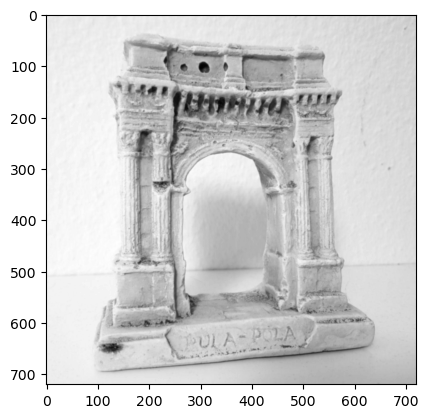

In [2]:

img = cv2.imread('images/harris_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

## Détecteur d'angle Moravec
Moravec a proposé un détecteur d'angle dans lequel nous glissons une fenêtre dans n'importe quelle direction et mesurons le changement d'intensité. Un virage est trouvé lorsqu’un mouvement dans au moins deux directions entraîne un changement important d’intensité.

![Moravec Corner Detector](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/moravec_corner_detector.png)
*Figure 7: Moravec Corner Detector. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Nous considérons une fenêtre/un patch à la position (x,y) et la déplaçons vers un nouvel emplacement (x+dx, y+dy). nous calculons ensuite que la somme des carrés des différences entre les deux patchs est grande pour deux paires dx et dy différentes, nous considérons que la région (x, y) contient un coin. 

![SSD of Moravec Corner Detector](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/ssd_moravec_corner_detector.png)
*Figure 8: SSD of Moravec Corner Detector. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Bien que l'approche de Moravec soit intuitive à comprendre, elle est également coûteuse en termes de calcul, car pour chaque emplacement de pixel, plusieurs positions de patch différentes doivent être calculées et comparées les unes aux autres.

(http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

## Détecteur de coin Harris / Shi-Tomasi
Harris implémente la détection des coins de Moravec sans avoir besoin de déplacer physiquement la fenêtre de patch. Pour ce faire, il examine le patch et calcule les dégradés, donc les dérivés.

Harris approxime le décalage (dx, dy) en utilisant le premier développement de Taylor : I(x + dx, y + dy) = I(x, y) + I<sub>x</sub>(x, y)dx + I <sub>y</sub>(x, y)dy.
Le SSD de (dx, dy) peut donc être approché en prenant la somme des carrés des différences entre les images dérivées dans la direction x (I<sub>x</sub>) et les images dérivées dans la direction y (I<sub >o</sub>).
Ces dérivées I<sub>x</sub>, I<sub>y</sub> peuvent simplement être calculées en utilisant un filtre Sobel normal.

![SSD of Harris Corner Detector](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/ssd_harris_corner_detector.png)
*Figure 9: SSD of Harris Corner Detector. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Pour implémenter cette formule, on peut écrire le SSD sous forme matricielle. Notez que dans la formule suivante, M est ce qu'on appelle une *matrice de second moment* contenant des produits par pixel de leur patch d'image respectif.

![SSD of Harris in Matrix representation](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_matrix.png)
*Figure 10: SSD of Harris in Matrix representation. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Pour calculer M, nous utilisons un Box Filter pour résumer les correctifs I<sup>2</sup><sub>x</sub>, I<sup>2</sup><sub>y</sub> et I<sub>x</sub>I<sub>y</sub>. Nous pourrions également utiliser un filtre en forme de boîte pour donner plus de poids aux pixels centraux. Le résultat est une matrice 2x2.

In [4]:
patch_size=9

In [5]:
def shi_tomasi(img, patch_size):
# Tout d'abord, nous définissons les filtres Sobel dans les directions x et y
sobel_x = np.array( [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]] )    
sobel_y = np.rot90(sobel_x, 3)
    
# Maintenant, nous calculons les dérivées de l'image dans les directions x (Ix) et y (Iy)
Ix = convolve2d(img, sobel_x, mode='valid')
Iy = convolve2d(img, sobel_y, mode='valid')
        
# Récapitulons la définition de la matrice M. On a besoin de la somme d'une Matrice sous la forme
# [[Ixx Ixy]
#  [Ixy Iyy]]
Ixx = Ix ** 2
Iyy = Iy ** 2
Ixy = Ix * Iy
    
# Pour obtenir M, nous devons faire une somme ponctuelle des patchs d'image (Ixx, Ixy, Iyy).
# Nous pouvons le faire intelligemment en convoluant les images avec un filtre qui a la taille de notre patch (disons 3x3)
# et ressemblez à ceci :
# [[1 1 1]
# [1 1 1]
# [1 1 1]]
# Cela aura pour résultat que le pixel central sera la somme des pixels voisins, y compris le pixel central
summation_filter = np.ones((patch_size, patch_size))
    
# Faisons maintenant une convolution de Ixx, Ixy et Iyy avec ce filtre de sommation
# Cela donnera trois matrices contenant à chaque position (u, v) la valeur de SUM(Ixx), SUM(Ixy) et SUM(Iyy)
# avec la taille de patch donnée. Pour obtenir la valeur de M à la position (u, v), on peut donc la construire comme suit :
# M = [[sum_Ixx(u, v) sum_Ixy(u, v)]
# [sum_Ixy(u, v) sum_Iyy(u, v)]]
sum_Ixx = convolve2d(Ixx, summation_filter, mode='valid')
sum_Ixy = convolve2d(Ixy, summation_filter, mode='valid')
sum_Iyy = convolve2d(Iyy, summation_filter, mode='valid')
    

    


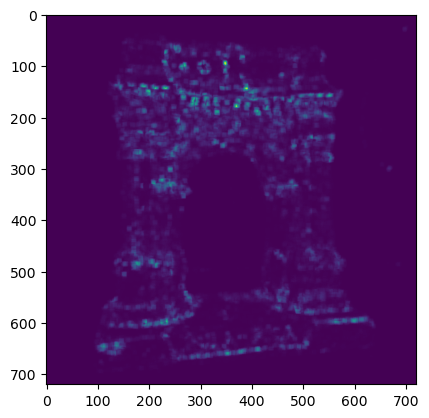

In [6]:

plt.imshow(score_image)



Rappelons que nous pouvons trouver les valeurs propres l<sub>1</sub>, l<sub>2</sub> et les vecteurs propres x d'une matrice carrée en résolvant l'équation suivante :

**Ax = $\lambda$x**

Nous pouvons trouver les valeurs propres en résolvant **det(A - $\lambda$I) = 0**

Puisque nous avons affaire à une matrice 2x2, nous pouvons facilement déterminer les valeurs propres as et les vecteurs propres en trois étapes :

![SSD of Harris in Matrix eigenvalues & eigenvectors](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_eigenvector.png)
*Figure 11: SSD of Harris in Matrix eigenvalues & eigenvectors. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

En résolvant les derniers calculs matriciels, nous obtenons deux vecteurs propres x, à partir desquels nous pouvons construire une matrice R = [x1|x2].

A partir de la matrice symétrique M, on peut faire une décomposition comme suit, avec les valeurs propres l<sub>1</sub> et l<sub>2</sub> et la matrice de vecteurs propres R :

![SSD of Harris in Matrix decomposition](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_matrix_decomposition.png)
*Figure 12: SSD of Harris in Matrix decomposition. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Nous pouvons alors visualiser [dx dy] M [dx dy]' comme une ellipse, où la longueur de l'axe de l'ellipse correspond exactement aux valeurs propres et l'orientation des axes sont les vecteurs propres de M. Les deux valeurs propres identifieront alors la direction du changement le plus grand et le plus petit. de SSD. L'axe le plus long indique l'ampleur (valeur propre) et la direction (vecteur propre) du changement le plus lent du SSD (changement lent en contraste), tandis que l'axe le plus court indique le changement le plus rapide du SSD, donc le bord le plus fort.

![Elilpses of Eigenvalues](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/elipses.png)
*Figure 14: Elilpses of Eigenvalues. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Pour une région plate, nous obtiendrons des valeurs propres l<sub>1</sub> et l<sub>2</sub> proches de 0. Pour une arête horizontale, nous obtiendrons une valeur élevée pour l<sub>2</sub> sub> et une valeur proche de zéro pour l<sub>1</sub>. Seulement si nous avons un coin, les deux valeurs propres seront nettement supérieures à 0. Pour une arête parfaitement perpendiculaire, nous obtiendrons des vecteurs propres avec une orientation de 45°.

![SSD of Harris in Matrix Eigenvalues](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/harris_corner_detector_eigenvalues.png)
*Figure 13: SSD  of Harris in Matrix Eigenvalues. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*




Il n’y a qu’un seul problème : le calcul des valeurs propres coûte cher. On peut donc remplacer la *cornerness-function* par quelque chose de plus simple :

$$\lambda_\pm = \frac{1}{2}\left(\textrm{tr}(M) \pm \sqrt{\textrm{tr}^2(M)-4\det(M)}\right)$$



In [ ]:
# Nous pouvons maintenant calculer la trace et le déterminant nécessaires pour Shi-Tomasi : det(M) - k * trace^2(M)
trace = sum_Ixx + sum_Iyy
determinant = sum_Ixx * sum_Iyy - sum_Ixy ** 2
    
# Nous pouvons maintenant calculer le score en utilisant la trace et le déterminant
scores = trace / 2 - ((trace / 2) ** 2 - determinant) ** 0.5    
scores[scores < 0] = 0
    
# Depuis que nous avons filtré notre image, elle a diminué de moitié par rapport au patch_radius + un pixel, que nous ajoutons à la fin maintenant comme
# pixel noir indiquant l'absence de réponse shi-tomasi
patch_radius = patch_size // 2
score_image= np.pad(scores, (patch_radius + 1, patch_radius + 1), 'constant')

Un coin peut désormais être identifié en faisant glisser un patch sur l'image, en calculant les valeurs propres de M et en vérifiant si le minimum des deux valeurs propres de M est supérieur à un certain seuil défini par l'utilisateur. 

Ainsi, si **R = min(l<sub>1</sub>, l<sub>2</sub>) > seuil**, nous avons identifié le patch devant contenir un coin. 

Si les deux valeurs propres sont inférieures au seuil, nous avons une région plate. Si une seule des valeurs propres est suffisamment élevée, la région contient un coin - un horizontal si seule la deuxième valeur propre l<sub>2</sub> dépasse le seuil, un vertical sinon.

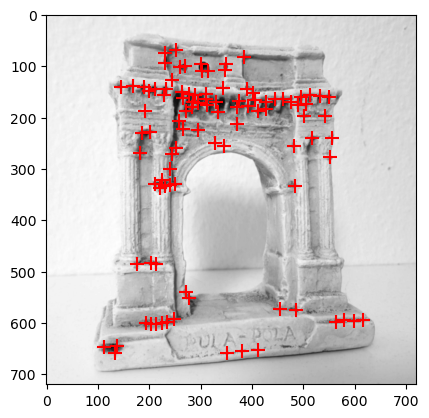

In [8]:
n_points, black_radius=100,9
# Puisque nous allons manipuler notre image (en rendre certaines parties floues), nous devons créer
# une copie de l'image d'entrée
score_image = np.array(score_image, copy=True)
    
# Définissons deux tableaux qui stockeront les coordonnées des entités
x_positions = np.zeros((n_points,))
y_positions = np.zeros((n_points,))
    
# Nous ajoutons autant de points que demandé via le paramètre n_points
for i in range(n_points):
        
        # Trouvez le point avec la valeur la plus élevée
        y, x = np.where(score_image == np.amax(score_image))
        x, y = x[0], y[0]
        
        # Définissez les coordonnées dans nos tableaux de positions
        x_positions[i] = x
        y_positions[i] = y
        
        # Réglez la région autour des coordonnées en noir pour éviter d'obtenir à peu près la même chose
         # coordonnées à nouveau dans la prochaine itération de boucle
        score_image[y-black_radius:y+black_radius, x-black_radius:x+black_radius] = 0
        
plt.imshow(img, cmap='gray')
plt.scatter(x=x_positions, y=y_positions, c='r', s=100, marker='+')

In [17]:

def shi_tomasi(img, patch_size):
    """
     Calcule la réponse d'angle shi-tomasi pour une image d'entrée donnée
    
     :param np.ndarray<float, float> img : patch d'image original de taille carrée
     :param int patch_size : chemin avec taille (patch_size x patch_size)
     :return : Nouvelle image contenant une réponse de coin utilisant la fonction Shi Tomasi à n'importe quel pixel
     :rtype: flottant
     """
    sobel_x = np.array( [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]] )
    sobel_y = np.rot90(sobel_x, 3) 
    Ix = convolve2d(img, sobel_x, mode='valid')
    Iy = convolve2d(img, sobel_y, mode='valid')        
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy  
    summation_filter = np.ones((patch_size, patch_size))
    sum_Ixx = convolve2d(Ixx, summation_filter, mode='valid')
    sum_Ixy = convolve2d(Ixy, summation_filter, mode='valid')
    sum_Iyy = convolve2d(Iyy, summation_filter, mode='valid')  
    trace = sum_Ixx + sum_Iyy
    determinant = sum_Ixx * sum_Iyy - sum_Ixy ** 2
    scores = trace / 2 - ((trace / 2) ** 2 - determinant) ** 0.5    
    scores[scores < 0] = 0
    patch_radius = patch_size // 2
    return np.pad(scores, (patch_radius + 1, patch_radius + 1), 'constant')
    
def select_n_keypoints(score_image, n_points, black_radius):
    """
     Détecte les n points avec la fonction d'angle la plus élevée dans l'image de partition et renvoie leurs coordonnées x, y
    
     :param np.ndarry score_image : contient un tableau 2D avec des valeurs représentant la sortie d'angle
     :param int n_points : nombre de points avec fonction d'angle maximal à sélectionner
     :param int black_radius : Rayon à annuler autour d'un point maximum déjà détecté
     :return : Deux listes de taille n_points contenant les coordonnées x et y des points
     :rtype : Tuple[int, int]
     """   
    score_image = np.array(score_image, copy=True)
    x_positions = np.zeros((n_points,))
    y_positions = np.zeros((n_points,))
    for i in range(n_points):
        y, x = np.where(score_image == np.amax(score_image))
        x, y = x[0], y[0]
        x_positions[i] = x
        y_positions[i] = y
        score_image[y-black_radius:y+black_radius, x-black_radius:x+black_radius] = 0
    return x_positions, y_positions


In [19]:
def extract_descriptors(img, x_positions, y_positions, radius):
    """ Extrait les descripteurs d'une image donnée, 
    étant donné les positions des coordonnées x et y et un rayon de descripteur 
    """
    # Initialiser un tableau vide pour stocker les descripteurs
    descriptor = []
    
    # Itérer sur les coordonnées (x,y)
    for i in range(len(x_positions)):
        x, y = int(x_positions[i]), int(y_positions[i])
        
        # Lire la zone autour de (x, y) et stocker le patch dans les descripteurs
        descriptor.append(img[y-radius:y+radius, x-radius:x+radius])
        
    return descriptor

# Get descriptors for image 1
img_1 = cv2.imread('images/harris_1.jpg' , cv2.IMREAD_GRAYSCALE)
score_image_1 = shi_tomasi(img_1, 9)
x_positions_1, y_positions_1 = select_n_keypoints(score_image_1, 100, 11)
descriptors_1 = extract_descriptors(img_1, x_positions_1, y_positions_1, radius=15)



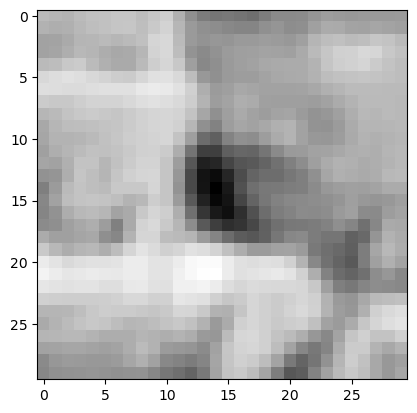

In [20]:
# Show a sample descriptor
plt.imshow(descriptor[0],'gray')

In [22]:
# Get descriptors for image 2
img_2 =cv2.imread('images/harris_1.jpg' , cv2.IMREAD_GRAYSCALE)
score_image_2 = shi_tomasi(img_2, 9)
x_positions_2, y_positions_2 = select_n_keypoints(score_image_2, 100, 11)
descriptors_2 = extract_descriptors(img_2, x_positions_2, y_positions_2, radius=15)


Ensuite, nous mettons en œuvre un analyseur de descripteurs par force brute qui recherche pour tout descripteur de la première image un descripteur correspondant dans la seconde image et stocke l'indice du descripteur correspondant le mieux dans un tableau.

In [30]:

# matches[i] = j
# Le descripteur de l'image 1 à la position i correspond au descripteur de l'image 2 avec l'index j.
# -1 pour les descripteurs de l'image 1 qui n'ont pas de correspondance dans l'image 2
matches = np.ones((len(descriptors_1), ), dtype=np.int8) * -1
    
# Boucle sur les descripteurs de l'image 1
for i in range(len(descriptors_1)):
        d1 = descriptors_1[i]
        best_ssd =np.inf
        
        # Boucle sur les descripteurs de l'image 2
        for j in range(len(descriptors_2)):
            d2 = descriptors_2[j]
            
            # Calculer le SSD
            ssd = np.average((d1 - d2) ** 2)/255
            
            # Remplacer la valeur à l'index i seulement si ssd est meilleur, le descripteur de l'image 2 n'est pas encore apparié à un descripteur de l'image 1, et le descripteur est suffisamment bon.
            # à aucun descripteur de l'image 1, et si le descripteur est suffisamment bon
            if ssd < best_ssd and not (j in matches):
                matches[i] = j
                best_ssd = ssd



In [31]:
matches

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int8)

Dans la liste des correspondances, nous trouvons pour chaque descripteur de la première image le descripteur équivalent dans la seconde image. Nous pouvons maintenant essayer de tracer les deux descripteurs en un seul tracé.

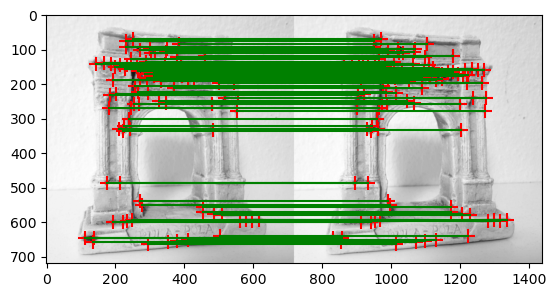

In [32]:
# Create a combined image and shift the x-positions of the second image
combined_img = np.concatenate((img_1, img_2), axis=1)
x_positions_2_shifted = x_positions_2 + len(img_1[0])
plt.imshow(combined_img, cmap='gray')

# Draw lines between all descriptors with valid matches (> -1)
for i in range(len(matches)):
    match = matches[i]
    if match > -1:
        plt.plot([x_positions_1[i], x_positions_2_shifted[match]], [y_positions_1[i], y_positions_2[match]], c='g')

# Draw descriptors for each image
plt.scatter(x=x_positions_1, y=y_positions_1, c='r', s=100, marker='+')
plt.scatter(x=x_positions_2_shifted, y=y_positions_2, c='r', s=100, marker='+')